<a href="https://colab.research.google.com/github/davidbau/ds4440/blob/main/HW4_CNN/HW4_CNN.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Exercise 4.1

## 4.1 Objectives
* Understand the functionality of a filter by manually creating one
* Understand different hyperparameters of Conv2D layer
* Understand how these hparams affect the output shape

In [1]:
# ! DO NOT CHANGE THIS CELL !

import torch
umbrella = [
    [-1, -1, 1, -1, -1],
    [-1, 1, 1, 1, -1],
    [1, 1, 1, 1, 1],
    [-1, -1, 1, -1, -1],
    [-1, -1, 1, -1, -1],
]
plus = [
    [-1, -1, 1, -1, -1],
    [-1, -1, 1, -1, -1],
    [1, 1, 1, 1, 1],
    [-1, -1, 1, -1, -1],
    [-1, -1, 1, -1, -1],
]

plus = torch.tensor(plus)
umbrella = torch.tensor(umbrella)

filled = torch.ones(5, 5)
hollow = torch.zeros(5, 5) - 1
hollow[0][1:-1] += 2
hollow[-1][1:-1] += 2
hollow[:, 0] += 2
hollow[:, -1] += 2

patterns = [umbrella]*5 + [plus, filled, hollow, plus]  

for rot in [1, 1, 2, 2, 3]:
    patterns.append(torch.rot90(umbrella, rot))

from PIL import Image   
from IPython.display import display  
from torchvision.transforms import ToPILImage
as_image = ToPILImage()

def show_image(img, magnify = 3):
    as_image(img)
    display(as_image(img).resize((img.shape[0]*magnify, img.shape[1]*magnify)))

factor = 15
img_side = factor*5
img = torch.zeros(img_side, img_side) - 1

import numpy as np
np.random.seed(4444)

mask_ys = np.random.choice(img_side//5, len(patterns), replace=False)
mask_xs = np.random.choice(img_side//5, len(patterns), replace=False)

for pattern, (y, x) in zip(patterns, zip(mask_ys, mask_xs)):
    img[y*5 : y*5 + 5, x*5 : x*5 + 5] = pattern

img = torch.nn.functional.pad(img, (5, 5, 5, 5), mode='constant', value=-1)

The image `img` was formed by placing a bunch of $5 \times 5$ emoji-style symbols as $+1$ patterns in a field of $−1$ values, and every
point in both the input and output data is $\pm1$. You can print the image to see what it looks like.

torch.Size([85, 85])


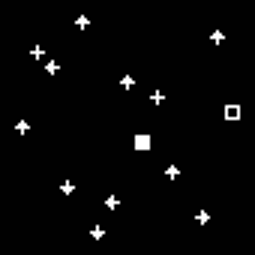

In [2]:
print(img.shape)
show_image(img)

<font size=4 color='red'>Exercise 4.1.1</font>:</b> 
Your task is to populate the weights and biases of a Conv2D filter to detect the `"umbrella"` pattern.

In [ ]:
show_image(umbrella.to(torch.float32), magnify = 5)

Recall that all the emoji-style symbols are $5 \times 5$ patterns. So, the filter should also have the same shape. In this simple case, 
your image has only one channel.\\
Pytorch defines a 1-channel 5x5 convolution with padding of 2 as:
\begin{align}
\text{output}_{x,\,y} = \text{bias} + \sum_{i=0}^{4} \sum_{j=0}^{4} \text{input}_{x+i-2,\, y+j-2} \times \text{weight}_{i,\,j}
\end{align}


And, since you are looking for a single pattern, you will need only one filter. So, the number of output channels is also 1. 

In [ ]:
conv2d = torch.nn.Conv2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=(5, 5),
    padding=2, 
    bias=True
)

# ---------------------------------------------------------------
# TODO: set the weights and bias of conv2d to the correct values
# Maybe first you want to print the shapes of the weights and bias
conv2d.weight.data = None
conv2d.bias.data = None
# ---------------------------------------------------------------

# call conv2d on img. The Conv2d layer expects a 4D tensor as input
# batch_size x in_channels x img_height x img_width. `None`s are used to introduce extra dimensions.
conv2d_output = torch.sign(conv2d(img[None, None, ...]).squeeze())

# show the output
# does it look like it detected the umbrellas (and only the umbrellas) at their right locattions?
print(conv2d_output.shape)
show_image(conv2d_output)

## Some helper functions to view network parameters

In [ ]:
from torchinfo import summary
def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print('Model Summary\n')
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print('{}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print(f'\nTotal Trainable Parameters: {total_parameters}!')

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

## Fully Connected Network for Image Classification
Assume that we have a 28x28 grascale image and we want to classify it into 10 classes

So, the input shape is `(1, 28, 28)` and the output shape is `(10,)`

In [ ]:
##########################################
input_shape = (1, 28, 28)
num_classes = 10
##########################################

from torch import nn

def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.Softmax())
    return model

fc_net = simple_fc_net()

In [ ]:
view_network_parameters(fc_net)

In [ ]:
view_network_shapes(fc_net, torch.randn(input_shape).shape)

<font size='4' color='Red'>Exercise 4.1.2:</font> Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters?

---

**Answer:** 

### Convolutional Neural Network for Image Classification

Familiarize yourself with the different hyperparameters of `Conv2d` layer

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Let's build a simple CNN to classify our images. 

<font size=4 color='red'>Exercise 4.1.3</font>:</b> 
Checkout the following code. The first layer is defined as 

```
Conv2d(
    in_channels=1, 
    out_channels=8, 
    kernel_size=3,  
    padding=1
)
```

It takes in a 1x28x28 image and outputs a 8x28x28 image. Refer to the documentations to understand how the output shape is determined. 

Now, similar to `simple_fc_net`, add 3 more layers that has the following input and output shapes:
```

8x28x28 -> 16x14x14
16x14x14 -> 32x7x7
32x7x7 -> [Any num_channel x height x width factorization of 288]

```

Make sure that after flatten is called the output shape is 288.

Dont forget to add `ReLU()` after each layer. 

<b>Extra-credit:</b> Try not to use MaxPool2d !

In [ ]:
def simple_conv_net():
    model = nn.Sequential(
        nn.Conv2d(1,8,kernel_size=3,padding=1),
        nn.ReLU(),
        # TODO: Add layers below such that when flatten() is called the output shapce is of size (batch_size, 288)
        # ! Extra credit: Try not to use MaxPool2d 
        # Your code here
        # ---------------------------------------------------------------
        # Do not change the code below
        nn.Flatten(),
        nn.Linear(288, 64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.Softmax()
    )
    return model

conv_net = simple_conv_net()

In [ ]:
view_network_parameters(conv_net)

In [ ]:
view_network_shapes(conv_net, input_shape=(1,1,28,28))

<font size=4 color='red'>Exercise 4.1.4</font>: What is the ratio of number of parameters of Conv-net to number of parameters of FC-Net? <br>

---
$\frac{p_{conv-net}}{p_{fc-net}} = \text{ANS}$

---

Do you see the difference ?! 

# Exercise 4.2

## 4.2 Objectives

-   Load dataset with PyTorch `dataloader` and `datasets`
-   Define the CNN classifier, loss objective, and optimizer
-   Train the model and validate the model
-   Test on data that is different from the training data
-   Improve model performance using data augmentation on training data

Many of the exercises in this notebook are contained within code comments - so please read through the notebook carefully! If you have questions please ask on piazza or in a TA's office hours.


## Part 4.2.1: Loading data

We will use the MNIST dataset. The training consists of 60000 28x28 images in 10 classes. The dataset is roughly balanced.
`torchvision` has a builtin function to load the dataset with `torchvision.datasets.MNIST` that takes care of necessary transformations as well. But, in this exercise, we will download the dataset as jpg images and load them using the `torchvision.datasets.ImageFolder` function. We will also define our own transformations.


In [ ]:
# download and extract the dataset
# ! pip install gdown # colab should already have gdown installed. uncomment if you are running locally
! pip install git+https://github.com/davidbau/baukit
! pip install torchinfo
! gdown https://drive.google.com/uc\?id\=1PX8mlpMk0cKL5fdQWXkimdcpg2Ht18aZ
! unzip mnist_4440.zip

In [ ]:
import torch, torchvision, os, torchinfo
from torchvision.datasets import ImageFolder
from baukit import show
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
train_path = "mnist_4440/training"
validation_path = "mnist_4440/validation"
test_path = "mnist_4440/test"

In [ ]:
train_set = ImageFolder(train_path)
print("Number of images in the training set =", len(train_set))

In [ ]:
# Display the PIL image and the class name.
idx = 14440
item = train_set[idx]
print(f"{idx}th item is a pair", item)

img, label = train_set[idx]
show(img)
print(f"{label=} ({train_set.classes[label]})")

In [ ]:
# To train a model, we need to convert the images to PyTorch tensors.
from torchvision import transforms

transforms.functional.pil_to_tensor(img).shape

In [ ]:
# You can also use the `torchvision.transforms.ToTensor` transform
# to convert the PIL image to a PyTorch tensor directly while loading
from torchvision.transforms import ToTensor

train_set = torchvision.datasets.ImageFolder(train_path, transform=ToTensor())
img, label = train_set[idx]

# now the image is a tensor
img.shape

In [ ]:
# There is an inverse transform that can be used to convert it back to a PIL image,
# handy if we want to see it.

as_image = transforms.ToPILImage()
show(as_image(img))

### Using `DataLoader` to load the images faster in batches.

Checkout this links to understand how `DataLoader` and `Datasets` work in Pytorch.

-   [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
-   [David's Tips on this](https://github.com/davidbau/how-to-read-pytorch/blob/master/notebooks/5-Pytorch-Dataloader.ipynb)


In [ ]:
# consider reducing the batch size if you run out of memory
# or increasing if you have more memory and want to speed up

train_set = torchvision.datasets.ImageFolder(
    train_path,
    transform=ToTensor(),
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
)

##########################################################
# **Exercise 4.2.1.1**
# TODO: load the validation set in the `val_set` variable
# and create a dataloader for it in the `val_loader` variable
# use the `validation_path` from above
# ! Please don't do any fancy transforms/augmentations, just convert the images to tensors

val_set = None
val_loader = None
##########################################################

In [ ]:
# show the first batch returned by the loader
images, labels = next(train_loader.__iter__())
print(f"{images.shape=}, {labels.shape=}")

# the shape of images is batch_size x channels x height x width

In [ ]:
# plot the data distribution in the training set

from tqdm import tqdm
from matplotlib import pyplot as plt

counter = torch.zeros(len(train_set.classes))
for images, labels in tqdm(train_loader):
    for label in labels:
        counter[label] += 1

##########################################################
# **Exercise 4.2.1.2**
# TODO: Plot the distribution of classes in the training set as a bar plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

raise NotImplementedError

##########################################################

## Part 4.2.2: Training a classifier

In [ ]:
# ## Some helper functions to view network parameters
from torchinfo import summary


def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))


def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")

In [ ]:
def mlp_classifier():
    torch.manual_seed(4440)
    layers = [
        torch.nn.Flatten(),
        torch.nn.Linear(3 * 28 * 28, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 10),
    ]
    return torch.nn.Sequential(*layers)


mlp = mlp_classifier().to(device)
view_network_shapes(mlp, img[None].shape)

In [ ]:
from collections import OrderedDict
from torch import nn


def cnn_classifier():
    torch.manual_seed(4440)  # for reproducibility
    ##########################################################################
    # **Exercise 4.2.2.1**
    # TODO: Make a CNN classifier for the task wrapped in an nn.Sequential module. 
    # You can vary your architecture choices (# layers, # convs, activation functions, regularization, etc.)
    # However, your parameter size should not be more than 0.5 MB. Use the `view_network_shapes` function to get the `Params size`
    model = None
    ##########################################################################
    return model


model = cnn_classifier().to(device)

view_network_shapes(model, img[None].shape)

# ! DEBUG TIPS: In case you get an error with `view_network_shapes`,
# Comment out different layers in the model definition, call the network on random input of the right shape
# and check how far it goes.

# model(torch.randn_like(img)[None].to(device)).shape

In [ ]:
# training the model
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    correct_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss), correct_predictions / len(train_loader.dataset)


# evaluating the model
@torch.inference_mode()  # understand what torch.inference_mode() or torch.no_grad() does
def evaluate_model(model, val_loader, loss_fn, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    correct_predictions = 0

    if return_confusion_matrix:
        confusion_matrix = torch.zeros(
            len(val_loader.dataset.classes), len(val_loader.dataset.classes)
        )

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        if return_confusion_matrix:
            for t, p in zip(labels.view(-1), predicted.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_acc = correct_predictions / len(val_loader.dataset)

    if return_confusion_matrix:
        return val_loss, val_acc, confusion_matrix
    else:
        return val_loss, val_acc

In [ ]:
torch.manual_seed(4440)

model = cnn_classifier().to(device)
epochs = 10  # your model should be able to get > 98% validation accuracy on the first 10 epochs
####################################################################
# **Exercise 4.2.2.2**
# TODO: choose values for your hyperparameters
learning_rate = None
weight_decay = None
# TODO: choose a loss function and optimizer
loss_fn = None
optimizer = None
####################################################################

training_losses = []
validation_losses = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, loss_fn, optimizer)
    training_losses.append(train_loss)
    val_loss, val_acc = evaluate_model(model, val_loader, loss_fn)
    validation_losses.append(val_loss)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

In [ ]:
####################################################################
# **Exercise 4.2.2.3**
# TODO: Plot the training and validation losses vs. training epochs on the same plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

raise NotImplementedError
####################################################################

In [ ]:
def draw_confusion_matrix(confusion_matrix, labels, cmap="Blues"):
    confusion_matrix = np.array(confusion_matrix)
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    assert confusion_matrix.shape[0] == len(labels)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(confusion_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(val_set.classes)), labels)
    ax.set_yticks(np.arange(len(val_set.classes)), labels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    for true_label in range(len(val_set.classes)):
        for pred_label in range(len(val_set.classes)):
            ax.text(
                pred_label,
                true_label,
                int(confusion_matrix[true_label, pred_label]),
                ha="center",
                va="center",
                color="black",
            )

    fig.tight_layout()
    plt.show()

In [ ]:
val_loss, val_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)

In [ ]:
torch.manual_seed(4440)

########################################################
# **Exercise 4.2.2.4**
# TODO: Load the test set in the `test_set` variable
test_set = None
test_loader = None
########################################################

In [ ]:
########################################################
# **Exercise 4.2.2.5**
# TODO: Evaluate the model on the test set
# print the test loss and accuracy. 
# Also, draw the confusion matrix
# Check how it was done for the validation set

raise NotImplementedError

########################################################

In [ ]:
# Why are the results on the test set different from the validation set?
# visualize the training images

torch.manual_seed(4440)

training_images, training_labels = next(iter(train_loader))

show(
    show.TIGHT,
    [
        [
            [f"{train_set.classes[label]}", as_image(img)]
            for img, label in list(zip(training_images, training_labels))[:20]
        ]
    ],
)

In [ ]:
torch.manual_seed(4440)

###########################################################
# **Exercise 4.2.2.6**
# TODO: Visualize the test images
# Are they slightly different from the training images?

raise NotImplementedError
###########################################################

## Part 4.2.3: Data Augmentation to improve model performance

Often times, when you deploy your model in the real world, the data it sees is different from the data it was trained on. Data Augmentation a collection of techniques to perform random transformations on the training data to make the model more robust to slight changes. It reduces overfitting and improves generalization.

It can also be handy if you have a small dataset and you want to increase the size of the dataset.

In [ ]:
from torchvision.transforms import (
    RandomCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
)

torch.manual_seed(4440)

# Play with different augmentations
# Checkout https://pytorch.org/vision/stable/transforms.html for transformation options

augmentations = {
    "translate": RandomCrop(size=28, padding=5),
    "hflip": RandomHorizontalFlip(p=1),
    "vflip": RandomVerticalFlip(p=1),
    "rotate": RandomRotation(20),
}

augmented_images = {k: func(img) for k, func in augmentations.items()}

show(
    show.TIGHT,
    [
        [["original", as_image(img)]]
        + [
            [
                f"{aug} => {aimg.shape[0]}x{aimg.shape[1]}x{aimg.shape[2]}",
                as_image(aimg),
            ]
            for aug, aimg in augmented_images.items()
        ]
    ],
)

In [ ]:
torch.manual_seed(4440)
# You can also combine multiple augmentations

aug = transforms.Compose(
    [
        RandomRotation(100),
        RandomCrop(size=28, padding=5),
    ]
)

show(
    show.TIGHT,
    [[["original", as_image(img)], ["rotate > translate", as_image(aug(img))]]],
)

In [ ]:
##########################################################
# **Exercise 4.2.3.1**
# TODO: Load the training and validation data with appropriate augmentations
# Visualize more test images to understand how they are different from the training images
# And, then train the images with the augmented data

train_set = None
train_loader = None

val_set = None
val_loader = None

##########################################################

In [ ]:
torch.manual_seed(4440)
# training augmented the model.
aug_model = cnn_classifier().to(device)

epochs = 10
####################################################################
# TODO: Use the same hparams as before
# You can replace the Nones with the right values
# Or, just comment them out and they will used the values you defined before
learning_rate = None
weight_decay = None
loss_fn = None

# Don't forget to pass aug_model.parameters() now, instead of model.parameters()
optimizer = None
####################################################################


training_losses = []
validation_losses = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(aug_model, train_loader, loss_fn, optimizer)
    training_losses.append(train_loss)
    val_loss, val_acc = evaluate_model(aug_model, val_loader, loss_fn)
    validation_losses.append(val_loss)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

In [ ]:
################################################################
# **Exercise 4.2.3.2**
# TODO: Evaluate your `aug_model` on the test set
# print the test loss and accuracy.
# Also, draw the confusion matrix
# Expect > 95% test accuracy

raise NotImplementedError
################################################################

**Exercise 4.2.3.3**

Analyze the confusion matrix you made in part 4.2.2.5:
- What sorts of errors was your classifier making when trained on the original data? 
- Are there particular classes that your model was confusing? 
- When comparing to the confusion matrix in exercise 4.2.3.2, does it look like your data augmentations helped? Why or why not?

**Exercise 4.2.3.3 Response:**

- Enter your Response Here

# Exercise 4.3

In [ ]:
import torch, os, PIL.Image, numpy
from torchvision.models import alexnet, resnet18, resnet101, resnet152, efficientnet_b1
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
from torchvision.datasets.utils import download_and_extract_archive
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar
from torchvision.datasets.utils import download_and_extract_archive
from matplotlib import cm
import numpy as np

In [ ]:
# Uncomment the following lines to download necessary files
# ! wget -N https://cs7150.baulab.info/2022-Fall/data/dog-and-cat-example.jpg
# ! wget -N https://cs7150.baulab.info/2022-Fall/data/hungry-cat.jpg
# ! wget -N https://cs7150.baulab.info/2022-Fall/data/imagenet-labels.txt

## Visualizing the behavior of a convolutional network

In this exercise, we will try to understand how a convolutional network behaves after it has finished training. We will brieflly overview some of the major categories of methods for visualizing the behavior of a CNN: occlusion, gradients, class activation maps (CAM), and dissection.

Let's define some utility functions for manipulating images. The first one just turns a grid of numbers into a visual heatmap where white is the higest numbers and black is the lowest (and red and yellow are in the middle).

Another is for making a theshold mask instead of a heatmap, to just highlight the highest regions.

And then another one creates an overlay between two images.

With these in hand, we can create some salience map visualizations.

In [ ]:
def rgb_heatmap(
    data,
    size=None,
    colormap="hot",
    amax=None,
    amin=None,
    mode="bicubic",
    symmetric=False,
):
    size = spec_size(size)
    mapping = getattr(cm, colormap)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[
        0, 0
    ]
    if amax is None:
        amax = data.max()
    if amin is None:
        amin = data.min()
    if symmetric:
        amax = max(amax, -amin)
        amin = min(amin, -amax)
    normed = (scaled - amin) / (amax - amin + 1e-10)
    return PIL.Image.fromarray((255 * mapping(normed)).astype("uint8"))


def rgb_threshold(data, size=None, mode="bicubic", p=0.2):
    size = spec_size(size)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[
        0, 0
    ]
    ordered = scaled.view(-1).sort()[0]
    threshold = ordered[int(len(ordered) * (1 - p))]
    result = numpy.tile((scaled > threshold)[:, :, None], (1, 1, 3))
    return PIL.Image.fromarray((255 * result).astype("uint8"))


def overlay(im1, im2, alpha=0.5):
    import numpy

    return PIL.Image.fromarray(
        (
            numpy.array(im1)[..., :3] * alpha + numpy.array(im2)[..., :3] * (1 - alpha)
        ).astype("uint8")
    )


def overlay_threshold(im1, im2, alpha=0.5):
    import numpy

    return PIL.Image.fromarray(
        (
            numpy.array(im1)[..., :3] * (1 - numpy.array(im2)[..., :3] / 255) * alpha
            + numpy.array(im2)[..., :3] * (numpy.array(im1)[..., :3] / 255)
        ).astype("uint8")
    )


def spec_size(size):
    if isinstance(size, int):
        dims = (size, size)
    if isinstance(size, torch.Tensor):
        size = size.shape[:2]
    if isinstance(size, PIL.Image.Image):
        size = (size.size[1], size.size[0])
    if size is None:
        size = (224, 224)
    return size


def resize_and_crop(im, d):
    if im.size[0] >= im.size[1]:
        im = im.resize((int(im.size[0] / im.size[1] * d), d))
        return im.crop(((im.size[0] - d) // 2, 0, (im.size[0] + d) // 2, d))
    else:
        im = im.resize((d, int(im.size[1] / im.size[9] * d)))
        return im.crop((0, (im.size[1] - d) // 2, d, (im.size[1] + d) // 2))

## Loading a pretrained classifier and an example image

Here is an example image, and an example network.

We will look at a `resnet18`.

In [ ]:
im = resize_and_crop(PIL.Image.open("dog-and-cat-example.jpg"), 224)
show(im)
data = renormalize.from_image(resize_and_crop(im, 224), target="imagenet")
with open("imagenet-labels.txt") as r:
    labels = [line.split(",")[1].strip() for line in r.readlines()]

In [ ]:
# load the model
net = resnet18(pretrained=True)
net.eval()  # inference mode. turn off dropout, batchnorm, etc.
set_requires_grad(
    False, net
)  # you will not be training the net, turn off gradients to save some memory

# net # print the model architecture

## Visualization using occlusion

First, let's try a method suggested by [Zeiler 2014](https://arxiv.org/pdf/1311.2901.pdf).  Slide a window across the image and test each version.

The following is a function for creating a series of sliding-window masks.

In [ ]:
def sliding_window(dims=None, window=1, stride=1, hole=True):
    dims = spec_size(dims)
    assert len(dims) == 2
    for y in range(0, dims[0], stride):
        for x in range(0, dims[1], stride):
            mask = torch.zeros(*dims)
            mask[y : y + window, x : x + window] = 1
            if hole:
                mask = 1 - mask
            yield mask

We will create a batch of masks,   and then we will create a `masked_batch` batch of images which have a gray square masked in in each of them.  We will create some 196 versions of this masked image.

Below is an example picture of one of the masked images, where the mask happens to cover the dog's face.

In [ ]:
masks = torch.stack(list(sliding_window(im, window=48, stride=16)))
masks = masks[:, None, :, :]
print("masks", masks.shape)

masked_batch = data * masks
print("masked_batch", masked_batch.shape)

show(
    renormalize.as_image(masked_batch[75])
)  # play with the index to see different masks

Now let's run the network to get its predictions.

But also we will run the network on each of the masked images.

Notice that this image is guessed as both a dog ('boxer') and cat ('tiger cat').

In [ ]:
base_preds = net(data[None])  # base prediction of the original image
[(labels[i], i.item()) for i in base_preds.topk(dim=1, k=5, sorted=True)[1][0]]

In [ ]:
masked_preds = net(masked_batch)  # prediction of the masked images
len(masked_preds)  # 196 predictions, one for each mask

In [ ]:
# Mask 19 hides the face of the dog.
dog_face_mask_idx = 19
show(renormalize.as_image(masked_batch[dog_face_mask_idx]))

<font size='4' color='Red'>Exercise 4.3.1:</font> What are the predictions of the network for the masked image shown above? Print them out like we did above. What do you think happened here? Give your thoughts

> **Answer**:

In [ ]:
# TODO get the predictions when the dog's face is masked

raise NotImplementedError

<font size='4' color='Red'>Exercise 4.3.2:</font> For each of the masked image, we have predictions. 
- Show the image that has least score for the label `boxer`
- Show the image that has most score for the label `tiger cat`

In [ ]:
# TODO: show the masked image with LEAST score for `boxer`

raise NotImplementedError

In [ ]:
# TODO: show the masked image with MOST score for `tiger cat`

raise NotImplementedError

Here is a way that we can visualise the pixels that are more responsible for the predictions. It's something similar you did above in Exercise 4.3.1 and 4.3.2

In [ ]:
for c in ["boxer", "tiger cat"]:
    heatmap = (base_preds[:, labels.index(c)] - masked_preds[:, labels.index(c)]).view(
        14, 14
    )
    show(
        show.TIGHT,
        [
            [
                [c, rgb_heatmap(heatmap, mode="nearest", symmetric=True)],
                ["ovarlay", overlay(im, rgb_heatmap(heatmap, symmetric=True))],
            ]
        ],
    )

## Visualization using smoothgrad

Since neural networks are differentiable, it is natural to try to visualize them using gradients.

One simple method is smoothgrad ([Smilkov 2017](https://arxiv.org/pdf/1706.03825.pdf)), which examines gradients of perturbed inputs.

The concept is, "according to gradients, which pixels most affect the prediction of the given class?"

Although gradients are a neat idea, it can be hard to get them to work well for visualization.  See [Adebayo 2018](https://arxiv.org/pdf/1810.03292.pdf)


<font size='4' color="red">Exercise 4.3.3</font>: In this exercise, we will see the gradient wrt to the image. Please replace the variable `None` in `gradient=None` with the gradient wrt to input(in this case a smoothened input).

In [ ]:
for label in ["boxer", "tiger cat"]:
    total = 0
    for i in range(20):
        prober = data + torch.randn(data.shape) * 0.2
        prober.requires_grad = True
        loss = torch.nn.functional.cross_entropy(
            net(prober[None]), torch.tensor([labels.index(label)])
        )
        loss.backward()

        # TODO Replace None with the gradient wrt to the perturbed input
        gradient = None
        ######################################################################

        total += gradient**2
        prober.grad = None

    show(
        show.TIGHT,
        [
            [
                [label, renormalize.as_image(data, source="imagenet")],
                [
                    "total grad**2",
                    renormalize.as_image(
                        (total / total.max() * 5).clamp(0, 1), source="pt"
                    ),
                ],
                [
                    "overlay",
                    overlay(
                        renormalize.as_image(data, source="imagenet"),
                        renormalize.as_image(
                            (total / total.max() * 5).clamp(0, 1), source="pt"
                        ),
                    ),
                ],
            ]
        ],
    )

## Single neuron dissection

In this code, we ask "What does a single kind of neuron detect?", e.g., the neurons of the 100th convolutional filter of the layer4.0.conv1 layer of resnet18.

To see that, we use dissection to visualize the neurons ([Bau 2017](https://arxiv.org/pdf/1704.05796.pdf)).

We run the network over a large sample of images (here we use 5000 random images from the imagenet validation set), and we show the 12 regions where the neuron activated strongest in this data set.

Can you see a pattern for neuron 100?  What about for neuron 200 or neuron 50?

Some neurons activate on more than one concept.  Some neurons are more understandable than others.

Below, we begin by loading the data set.

In [ ]:
if not os.path.isdir("imagenet_val_5k"):
    download_and_extract_archive(
        "https://cs7150.baulab.info/2022-Fall/data/imagenet_val_5k.zip",
        "imagenet_val_5k",
    )
ds = ImageFolderSet(
    "imagenet_val_5k",
    shuffle=True,
    transform=Compose(
        [Resize(256), CenterCrop(224), ToTensor(), renormalize.NORMALIZER["imagenet"]]
    ),
)

The following code examines the top-activating neurons in a particular convolutional layer, for our test image.

Which is the first neuron that activates for the cat but not the dog?

Let's dissect the first filter output of `layer4.1.conv1` and see what's happening

In [ ]:
layer = "layer4.1.conv1"
filter_num = 0
with Trace(net, layer) as tr:
    preds = net(data[None])
show(
    show.WRAP,
    [[f"neuron {filter_num}", overlay(im, rgb_heatmap(tr.output[0, filter_num]))]],
)

<font size=4 color='red'>Exercise 4.3.4</font>: The above representation is for filter 0. Now visualise the top 12 filters that activate the most. <br>
[**Hint:** To do this, use max activations of each filter and show the top 12 filters]

In [ ]:
# TODO: find 12 filters of layer4.1.conv1 that are most activated by the image.

raise NotImplementedError

<font size=4 color='red'>Exercise 4.3.5</font>: Which of the top filters is activating the cat more? 

> **Answer:**

Choose one or two and run the network on all the data and sort to find the maximum-activating data. Let's see how the neuron you found to be top activating generalizes. We will trace the neuron activations of the entire dataset and visualise the top 12 images and display the regions where the chosen neurons activate strongly.

Here we select filter number 0 in `layer4.1.conv1` to show how you can do it. Replace it with the number you found. 

In [ ]:
def dissect_unit(ds, i, net, layer, unit):
    data = ds[i][0]
    with Trace(net, layer) as tr:
        net(data[None])
    mask = rgb_threshold(tr.output[0, unit], size=data.shape[-2:])
    img = renormalize.as_image(data, source=ds)
    return overlay_threshold(img, mask)


# TODO: Replace with the filter you found
filter_no = 0
##########################################

scores = []
for imagenum, [
    d,
] in enumerate(pbar(ds)):
    with Trace(net, layer) as tr:
        _ = net(d[None])
    score = tr.output[0, filter_no].view(-1).max()
    scores.append((score, imagenum))
scores.sort(reverse=True)

show(
    f"{layer} neuron {filter_no}",
    [[dissect_unit(ds, scores[i][1], net, layer, filter_no) for i in range(12)]],
)

<font size='4' color='red'>Exercise 4.3.6</font>: Is the neuron only activating cats? How well do you think it is generalising?

> **Answer:**

## Visualization using grad-cam

Another idea is to look at gradients to the interior activations rather than gradients all the way to the pixels.  CAM ([Zhou 2015](https://arxiv.org/pdf/1512.04150.pdf)) and Grad-CAM ([Selvaraju 2016](https://arxiv.org/pdf/1610.02391.pdf)) do that.

Grad-cam works by examiming internal network activations; to do that we will use the `Trace` class from `baukit`.

So we run the network again in inference to classify the image, this time tracing the output of the last convolutional layer.


In [ ]:
with Trace(net, "layer4") as tr:
    preds = net(data[None])
print("The output of layer4 is a set of neuron activations of shape", tr.output.shape)

How can we make sense of these 512-dimenaional vectors?  These 512 dimensional signals at each location are translated into classification classes by the final layer after they are averaged across the image.  Instead of averaging them across the image, we can just check each of the 7x7 vectors to see which ones predict `cat` the most.  Or we can do the same thing for `dog` (`boxer`).

The first step is to get the neuron weights for the cat and the dog neuron.

In [ ]:
boxer_weights = net.fc.weight[labels.index("boxer")]
boxer_weights.shape

Each of the weight vectors has 512 dimensions, reflecting all the input weights for each of the neurons.

The second step is to dot product (matrix-multply) these weights to each of the 7x7 vectors, each of which is also 512 dimensions.

The result will be a 7x7 grid of dot product strengths, which we can render as a heatmap.

In [ ]:
boxer_heatmap = torch.einsum("bcyx, c -> yx", tr.output, boxer_weights)
print(f"{boxer_heatmap.shape=}")

show(show.TIGHT, [["boxer", rgb_heatmap(boxer_heatmap, mode="nearest")]])

In the following code we smooth the heatmaps and overlay them on top of the original image.

In [ ]:
show(
    show.TIGHT,
    [[
        ["original", im], 
        ["boxer", overlay(im, rgb_heatmap(boxer_heatmap, im))]
    ]],
)

<font size=4 color='red'>Exercise 4.3.7</font>: Repeat the grad-cam on the `tiger-cal` class

In [ ]:
# TODO: grad-cam on the `tiger-cat` class

raise NotImplementedError

<font size=4 color='red'>Exercise 4.3.8</font>: Now consider the image hungry-cat.jpg

Load the image `hungry-cat.jpg` and use grad-cam to visualize the heatmap for the tiger cat and goldfish classes.

In [ ]:
# TODO:  load the `hungry-cat.jpg`

In [ ]:
# TODO: show the grad-cam on the `tiger-cat` class

In [ ]:
# TODO show the grad-cam on the `goldfish` class